In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

from DataSet import DataSet
from Circuit import Circuit

from qat.interop.qiskit import qlm_to_qiskit

from qiskit.circuit import QuantumCircuit, Parameter
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


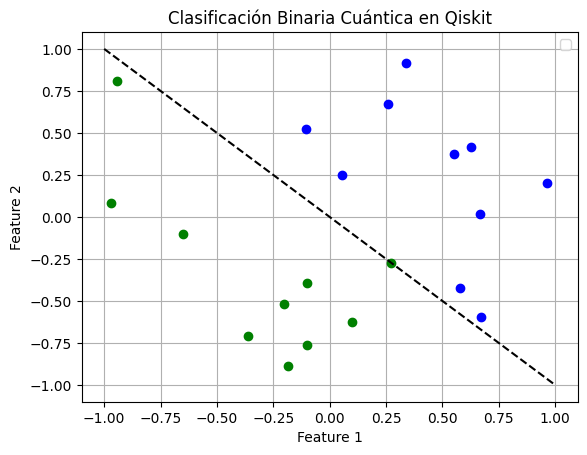

In [2]:
#Instanciamos la clase DataSet y mostramos un diagrama los datos
dataset = DataSet(seed=40)
dataset.Draw()

In [3]:
#Instaciamos la clase circuito donde creamos un circuito cuantico y añadimos el encoding y el circuito variacional
circuit = Circuit()
circuit.ZZFeatureMap()
circuit.varCircuit1()

#Mostramos el circuito
circuit.display()

In [4]:
#Mediante interoperabilidad exportamos el circuito a qiskit
qlm_circuit = circuit.circuit()
qiskit_circuit = qlm_to_qiskit(qlm_circuit)
qiskit_circuit.remove_final_measurements()

#Mostrmos el circuito
qiskit_circuit.draw()

┌───┐┌──────────────────┐┌──────────────────┐     »
q0_0: ┤ H ├┤ Rz(2.0*varData0) ├┤ Rz(2.0*varData1) ├──■──»
      ├───┤└──────────────────┘└──────────────────┘┌─┴─┐»
q0_1: ┤ H ├────────────────────────────────────────┤ X ├»
      └───┘                                        └───┘»
«                                                    ┌───┐┌──────────────────┐»
«q0_0: ───────────────────────────────────────────■──┤ H ├┤ Rz(2.0*varData0) ├»
«      ┌───────────────────────────────────────┐┌─┴─┐├───┤└──────────────────┘»
«q0_1: ┤ Rz(2.0*(π - varData0)*(π - varData1)) ├┤ X ├┤ H ├────────────────────»
«      └───────────────────────────────────────┘└───┘└───┘                    »
«      ┌──────────────────┐                                                   »
«q0_0: ┤ Rz(2.0*varData1) ├──■─────────────────────────────────────────────■──»
«      └──────────────────┘┌─┴─┐┌───────────────────────────────────────┐┌─┴─┐»
«q0_1: ────────────────────┤ X ├┤ Rz(2.0*(π - varData0)*(π - varData1)) ├┤ X ├»
«                          └───┘└───────────────────────────────────────┘└───┘»
«      ┌───────────────┐     ┌───────────────┐     ┌───────────────┐»
«q0_0: ┤ Ry(varTheta0) ├──■──┤ Ry(varTheta2) ├──■──┤ Ry(varTheta4) ├»
«      ├───────────────┤┌─┴─┐├───────────────┤┌─┴─┐└───────────────┘»
«q0_1: ┤ Ry(varTheta1) ├┤ X ├┤ Ry(varTheta3) ├┤ X ├─────────────────»
«      └───────────────┘└───┘└───────────────┘└───┘                 »
«      ┌───────────────┐     ┌───────────────┐
«q0_0: ┤ Ry(varTheta5) ├──■──┤ Ry(varTheta6) ├
«      └───────────────┘┌─┴─┐├───────────────┤
«q0_1: ─────────────────┤ X ├┤ Ry(varTheta7) ├
«                       └───┘└───────────────┘

In [5]:
#Usamos un estimador que se puede utilizar para clasicficacion
estimator_qnn = EstimatorQNN(
    circuit=qiskit_circuit, input_params=qiskit_circuit.parameters[:2], weight_params=qiskit_circuit.parameters[2:]
)

In [6]:
# QNN mapea los inputs de [-1, +1]
estimator_qnn.forward(dataset.X_aux[0, :], algorithm_globals.random.random(estimator_qnn.num_weights))

array([[0.63765115]])

In [7]:
#Funcion callback que dibuja una grafica en vivo cuando llamamos al metodo .fit()
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [8]:
#Construimos un clasificador de red neuronal
estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=60), callback=callback_graph
)

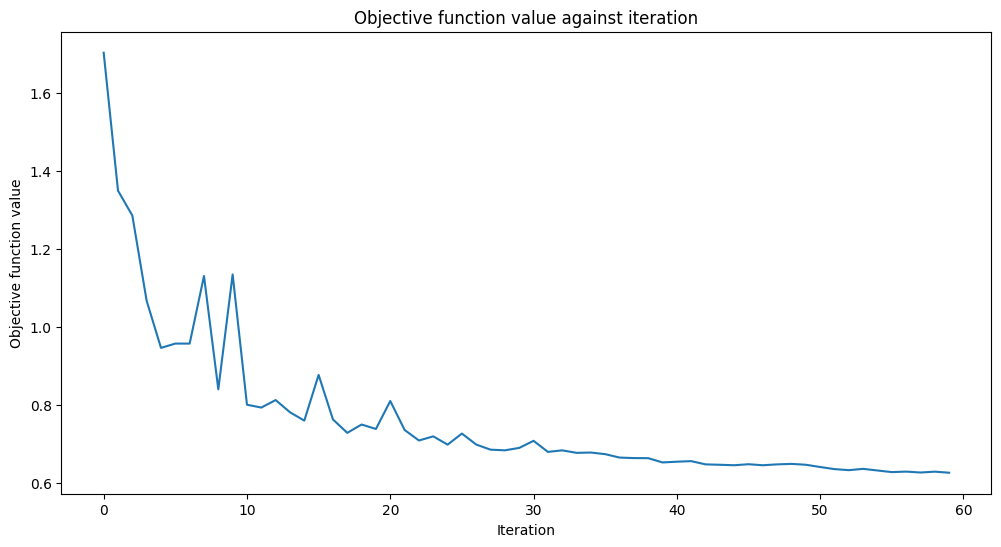

0.85

In [9]:
# Crearmos una matriz vacía para almacenar evaluaciones de la función objetivo
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# Ajustamos el clasificador a los datos
estimator_classifier.fit(dataset.X_aux, dataset.y)

# Volvemos al tamaño de figura predeterminado
plt.rcParams["figure.figsize"] = (6, 4)

# Evaluamos el clasificador
estimator_classifier.score(dataset.X_aux, dataset.y)

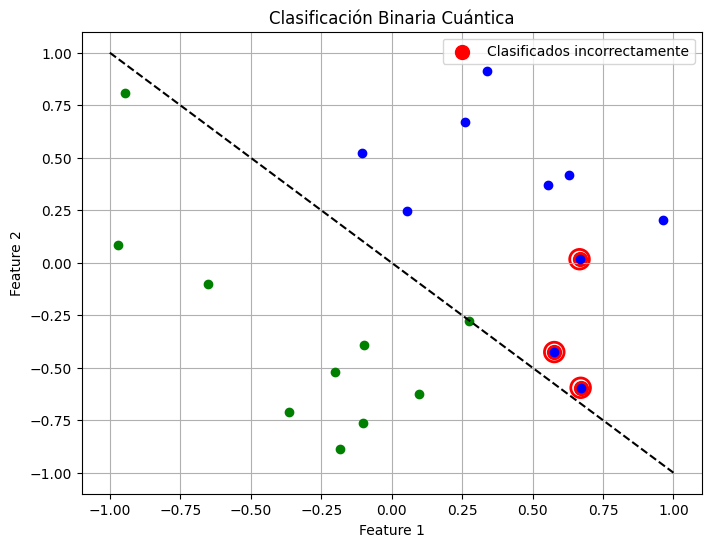

In [10]:
misclassified_indices = []

# Calcula las predicciones para cada punto y almacena los índices de los mal clasificados
y_predict = estimator_classifier.predict(dataset.X_aux)
for idx, (y_target, y_p) in enumerate(zip(dataset.y, y_predict)):
    if y_target != y_p:
        misclassified_indices.append(idx)

# Plotea los datos
plt.figure(figsize=(8, 6))
for idx, (x, y_target, y_p) in enumerate(zip(dataset.X_aux, dataset.y, y_predict)):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if idx in misclassified_indices:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)

# Plotea los puntos clasificados incorrectamente
incorrectly_classified = dataset.X_aux[misclassified_indices]
plt.scatter(incorrectly_classified[:, 0], incorrectly_classified[:, 1], c='red', s=100, label='Clasificados incorrectamente')

plt.plot([-1, 1], [1, -1], "--", color="black")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Clasificación Binaria Cuántica')
plt.legend()
plt.grid(True)
plt.show()